<a href="https://colab.research.google.com/github/ElFosco/NLP_argument_creation/blob/main/Predictor_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

Install the libraries, then restart the runtime, then re-install the libraries.

In [1]:
!pip install -q tf-models-official

In [2]:
!pip install tensorflow-text

In [3]:
pip install torch>=1.6.0 transformers>=4.11.3 sentencepiece

In [4]:
pip install numpy requests nlpaug

     |████████████████████████████████| 410 kB 5.2 MB/s 


# Import

In [6]:
!git clone https://github.com/ElFosco/NLP_argument_creation.git #necessary for the data

fatal: destination path 'NLP_argument_creation' already exists and is not an empty directory.


In [5]:
import os
import shutil

import re
import numpy as np
import math

import pandas as pd

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa

import keras
from keras import backend as K

from sklearn import metrics

from official.nlp import optimization  # to create AdamW optimizer

import nlpaug.augmenter.word as naw #data augmentation

import seaborn as sns
from matplotlib import pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


#Data Exploration

In [9]:
# Using google drive to upload the data
from google.colab import drive
drive.mount('/content/drive')

dir_path = "/content/NLP_argument_creation/Data/"
dataset = "arg_quality_rank_30k.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df = pd.read_csv(dir_path + dataset)
df.head()

,argument,topic,set,WA,MACE-P,stance_WA,stance_WA_conf
0,"""marriage"" isn't keeping up with the times. a...",We should abandon marriage,train,0.846165,0.297659,1,1.000000
1,.a multi-party system would be too confusing a...,We should adopt a multi-party system,train,0.891271,0.726133,-1,1.000000
2,\ero-tolerance policy in schools should not be...,We should adopt a zero-tolerance policy in sch...,dev,0.721192,0.396953,-1,1.000000
3,`people reach their limit when it comes to the...,Assisted suicide should be a criminal offence,train,0.730395,0.225212,-1,1.000000
4,"100% agree, should they do that, it would be a...",We should abolish safe spaces,train,0.236686,0.004104,1,0.805517


#Data Preprocessing

In [12]:
lemmatizer = WordNetLemmatizer()
def clean_text(text):
  text = re.sub('\"|-|\\\\|`', ' ', text)  # delete this chars from the string ["-\`]
  text = re.sub('\n', ' ', text)
  text = re.sub('^[.]+', '', text)         # delete dots at the beginning of the sentence
  text = re.sub("([?.!,])", r" \1 ", text)
  text = re.sub('\. \.', '.', text)        # delete . .
  text = re.sub('&', ' and ', text)        # replace & with and
  text = re.sub(' +', ' ', text)           # delete additional whitespace
  text = text.rstrip()                  
  text = text.lstrip()
  text = " ".join([lemmatizer.lemmatize(x) for x in text.split()])
  return text

In [13]:
df.loc[2, "argument"] = "zero tolerance policy in schools should not be adopted as circumstances are often not black and white, being more nuanced. no one should be written off due to a mistake of judgement."
df['argument'] = df.apply(lambda row : clean_text(row['argument']), axis = 1)


##Data Split

In [14]:
is_training_data =  df['set']=='train'
is_validation_data =  df['set']=='dev'
is_test_data =  df['set']=='test'

training_data = df[is_training_data]
validation_data = df[is_validation_data]
test_data  = df[is_test_data ]

x_train = training_data['argument'].reset_index(drop=True)
Y_train = training_data['MACE-P'].reset_index(drop=True)

x_val = validation_data['argument'].reset_index(drop=True)
Y_val = validation_data['MACE-P'].reset_index(drop=True)

x_test = test_data['argument'].reset_index(drop=True)
Y_test = test_data['MACE-P'].reset_index(drop=True)

#Data Augmentation

In [15]:
def create_augmented_data(x,Y):                   # run this two cells if you want to create other augmented data
                                                  # right now, we have created around 8k of new data
  back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
  )

  tmp_df = pd.DataFrame()
  for i in range(8000,int(x.shape[0])):
    print('['+str(i+1)+'/'+str(int(x.shape[0])+1)+']')
    new_argument = back_translation_aug.augment(x[i])
    score = Y[i]
    tmp = {'argument': new_argument, 'score': score}
    tmp_df = tmp_df.append(tmp,ignore_index=True)
    if ((i+1)%500)==0:
      print("Print on file:"+str(int(i+1)))
      tmp_df.to_csv(dir_path+"aug_"+str(int(i+1))+".csv", index=False, encoding='utf-8-sig')
      tmp_df = pd.DataFrame()
  tmp_df.to_csv(dir_path+"aug.csv", index=False, encoding='utf-8-sig')


In [ ]:
create_augmented_data(x_train,Y_train)

##Read augmented data

In [17]:
def read_aug_data():                                      #read augmented data, from the one collected, right now there are 8k new data
  ris = pd.DataFrame()
  for i in range(500,8500,500):
    df = pd.read_csv(dir_path+"aug_"+str(int(i))+".csv")
    ris = ris.append(df)
  return ris

In [18]:
ris_aug = read_aug_data()

In [19]:
x_train_aug = ris_aug['argument']
Y_train_aug = ris_aug['score']

#Data from UKP

In [21]:
ukp_path = dir_path + "UKPConvArg1-Ranking-CSV/"            #read data from UKP dataset, these will be splitted into
i=0                                                         #training, validation and test set
ukp_dataset_train = pd.DataFrame()
ukp_dataset_valid = pd.DataFrame()
ukp_dataset_test = pd.DataFrame()
for csv in os.listdir(ukp_path):
  if i<=20:
    df = pd.read_csv(ukp_path+csv,sep='\t')
    ukp_dataset_train = ukp_dataset_train.append(df)
  elif 20<i<=25 :
    df = pd.read_csv(ukp_path+csv,sep='\t')
    ukp_dataset_valid = ukp_dataset_valid.append(df)
  else:
    df = pd.read_csv(ukp_path+csv,sep='\t')
    ukp_dataset_test = ukp_dataset_test.append(df)
  i+=1

print(ukp_dataset_train.shape)
print(ukp_dataset_valid.shape)
print(ukp_dataset_test.shape)


(693, 3)
(167, 3)
(192, 3)


In [22]:
lemmatizer = WordNetLemmatizer()
def clean_text_ukp(text):
  text = text.lower()
  text = re.sub('\"|-|\\\\|`|/|\'', ' ', text)  # delete this chars from the string ["-\`]
  text = re.sub('<br/>', ' ', text)
  text = re.sub(':\)', ' ', text)
  text = re.sub('[\.]+[\.]+', ' ', text)         # delete ...
  #text = re.sub("([?.!,])", r" \1 ", text)
  text = re.sub('&', ' and ', text)        # replace & with and
  text = re.sub(' +', ' ', text)           # delete additional whitespace
  text = text.rstrip()                  
  text = text.lstrip()
  text = " ".join([lemmatizer.lemmatize(x) for x in text.split()])
  return text
  

In [23]:
ukp_dataset_train['argument'] = ukp_dataset_train.apply(lambda row : clean_text_ukp(row['argument']), axis = 1)
ukp_dataset_valid['argument'] = ukp_dataset_valid.apply(lambda row : clean_text_ukp(row['argument']), axis = 1)
ukp_dataset_test['argument'] = ukp_dataset_test.apply(lambda row : clean_text_ukp(row['argument']), axis = 1)

x_train_ukp = ukp_dataset_train['argument']
Y_train_ukp = ukp_dataset_train['rank']

x_val_ukp = ukp_dataset_valid['argument']
Y_val_ukp = ukp_dataset_valid['rank']

x_test_ukp = ukp_dataset_test['argument']
Y_test_ukp = ukp_dataset_test['rank']

#Final Dataset

In [32]:
is_augmented_added = False        #flag indicating if you want to add the augmented dataset
is_ukp_added = False              #flag indicating if you want to add the ukp dataset

In [33]:
def generate_final_dataset(x_train,Y_train,x_val,Y_val,x_test,Y_test,
                           x_train_aug,Y_train_aug,
                           x_train_ukp,Y_train_ukp,x_val_ukp,Y_val_ukp,x_test_ukp,Y_test_ukp,
                           is_augmented_added,is_ukp_added):
  
  if is_augmented_added==True:

    x_train = (x_train.append(x_train_aug)).reset_index(drop=True)
    Y_train = (Y_train.append(Y_train_aug)).reset_index(drop=True)
  
  if is_ukp_added==True:

    x_train = (x_train.append(x_train_aug)).reset_index(drop=True)
    Y_train = (Y_train.append(Y_train_aug)).reset_index(drop=True)

    x_val = (x_val.append(x_val_ukp)).reset_index(drop=True)
    Y_val = (Y_val.append(Y_val_ukp)).reset_index(drop=True)

    x_test = (x_test.append(x_test_ukp)).reset_index(drop=True)
    Y_test = (Y_test.append(Y_test_ukp)).reset_index(drop=True)

  return x_train,Y_train,x_val,Y_val,x_test,Y_test

In [34]:
x_train,Y_train,x_val,Y_val,x_test,Y_test= generate_final_dataset(x_train,Y_train,
                                                                  x_val,Y_val,
                                                                  x_test,Y_test,
                                                                  x_train_aug,Y_train_aug,
                                                                  x_train_ukp,Y_train_ukp,
                                                                  x_val_ukp,Y_val_ukp,
                                                                  x_test_ukp,Y_test_ukp,
                                                                  is_augmented_added,is_ukp_added)

#[Bert](https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb)



In [37]:
# @title Choose a BERT model to fine-tune

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  # @param ["bert_en_uncased_L-24_H-1024_A-16","bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [38]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) #preprocessing layer

In [39]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)               #bert model

In [40]:
def build_classifier_model(dense_size=100):                     #model used to compute the score of the argument
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(dense_size, activation=keras.activations.relu, name='fc_1')(net)
  net = tf.keras.layers.Dense(1, activation=keras.activations.sigmoid, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [41]:
classifier_model = build_classifier_model()

In [42]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [43]:
def pearson_loss(y_true, y_pred):   #loss used to optimize the bert model, in the end MSE turned out to be better
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = -r_num / r_den
    return K.mean(r)

def pearson_metric(y_true, y_pred): #metric used to do some analysis for the data
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

loss = pearson_loss
loss = tf.keras.losses.MeanSquaredError()

metric_pearson = pearson_metric
metric_mse = tf.keras.metrics.MeanSquaredError()

#Grid Search

In [ ]:
parameters = {'epochs': [1,2,3], 
              'batch_size':[32],
              'init_lr': [3e-6,3e-5],
              'dense_size' : [100,200,300],
              'loss' : [tf.keras.losses.MeanSquaredError(), pearson_loss]
              }

best_scores = -1
best_params = {1: dict()}

for loss in parameters['loss']:
  print("Loss: ", loss)
  for epochs in parameters['epochs']:
    print(" Epochs: ", epochs)
    for init_lr in parameters['init_lr']:
      print("  Start Learning Rate: ", init_lr)
      for batch_size in parameters['batch_size']:
        print("   Batch Size: ", batch_size)
        for dense_size in parameters['dense_size']:
          print("    Dense size: ", dense_size)
          steps_per_epoch = x_train.shape[0] / batch_size 
          num_train_steps = steps_per_epoch * epochs
          num_warmup_steps = int(epochs * x_train.shape[0] * 0.1 / batch_size)
          optimizer = optimization.create_optimizer(init_lr=init_lr, 
                                                    num_train_steps=num_train_steps, 
                                                    num_warmup_steps=num_warmup_steps, 
                                                    optimizer_type='adamw')
          classifier_model = build_classifier_model(dense_size)
          classifier_model.compile(optimizer=optimizer, loss=loss, 
                                   metrics=[metric_pearson, metric_mse])
          history = classifier_model.fit(x=x_train, y=Y_train, epochs=epochs, 
                                         batch_size=batch_size)
          loss_calculated, pearson ,mse = classifier_model.evaluate(x=x_val, 
                                                                    y=Y_val)
          print("     Pearson: ", pearson)
          print("     MSE: ", mse)
          if pearson > best_scores:                 
            best_score = pearson
            best_params = {'epochs': epochs, 
                           'batch_size': batch_size, 
                           'start_lr': init_lr,  
                           'dense_size': dense_size,
                           'loss': loss_calculated}
print(best_scores)
print(best_params)

Loss:  <keras.losses.MeanSquaredError object at 0x7f62cc1c2dd0>
 Epochs:  2
  Start Learning Rate:  3e-05
   Batch Size:  32
    Dense size:  100
Epoch 1/2
656/656 [==============================] - 1456s 2s/step - loss: 0.1087 - pearson_metric: 0.4440 - mean_squared_error: 0.1087
Epoch 2/2
101/101 [==============================] - 81s 792ms/step - loss: 0.0977 - pearson_metric: 0.4789 - mean_squared_error: 0.0977
     Pearson:  0.47894126176834106
     MSE:  0.09766768664121628
Loss:  <function pearson_loss at 0x7f62c6746e60>
 Epochs:  2
  Start Learning Rate:  3e-05
   Batch Size:  32
    Dense size:  100
Epoch 1/2
656/656 [==============================] - 1456s 2s/step - loss: -0.4633 - pearson_metric: 0.4632 - mean_squared_error: 0.1534
Epoch 2/2
101/101 [==============================] - 81s 790ms/step - loss: -0.4863 - pearson_metric: 0.4843 - mean_squared_error: 0.1314
     Pearson:  0.48425066471099854
     MSE:  0.1314152330160141
-1
{'epochs': 2, 'batch_size': 32, 'start_lr

# Training

In [ ]:
# Best parameter found on grid search
parameters = {'epochs': 2, 
              'batch_size': 32,
              'init_lr': 3e-5,
              'dense_size': 100,
              'loss': tf.keras.losses.MeanSquaredError()
              }

epochs = parameters['epochs']
batch_size = parameters['batch_size']
init_lr = parameters['init_lr']
dense_size = parameters['dense_size']
loss = parameters['loss']

steps_per_epoch = (x_train.append(x_val)).shape[0] / batch_size 
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(epochs * ((x_train.append(x_val)).shape[0]) * 0.1 / batch_size)
optimizer = optimization.create_optimizer(init_lr=init_lr, 
                                          num_train_steps=num_train_steps, 
                                          num_warmup_steps=num_warmup_steps, 
                                          optimizer_type='adamw')
classifier_model = build_classifier_model(dense_size)
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metric_pearson, 
                                                                  metric_mse])
history = classifier_model.fit(x=(x_train.append(x_val)).reset_index(drop=True), y=(Y_train.append(Y_val)).reset_index(drop=True), 
                               epochs=epochs, batch_size=batch_size)
loss_calculated, pearson, mse = classifier_model.evaluate(x_test, Y_test)
print("Pearson: ", pearson)
print("MSE: ", mse)

Epoch 1/2
756/756 [==============================] - 1277s 2s/step - loss: 0.1078 - pearson_metric: 0.4523 - mean_squared_error: 0.1078
Epoch 2/2
198/198 [==============================] - 125s 625ms/step - loss: 0.1035 - pearson_metric: 0.4533 - mean_squared_error: 0.1035
Pearson:  0.4533013701438904
MSE:  0.1034751832485199


# Save model

In [ ]:
classifier_model.save("drive/MyDrive/Colab Notebooks/NLP/classifierIBM30k.h5")

#Data analysis

In [ ]:
ris = classifier_model.predict(x_test)

In [ ]:
mse = [0] * 10
mse_size = [0] * 10
for i in range(len(Y_test)):
  mse[math.ceil(ris[i][0]*10)-1] += (ris[i][0]-Y_test[i])**2
  mse_size[math.ceil(ris[i][0]*10)-1] +=1
for i in range(len(mse)):
 mse[i]=mse[i]/mse_size[i]

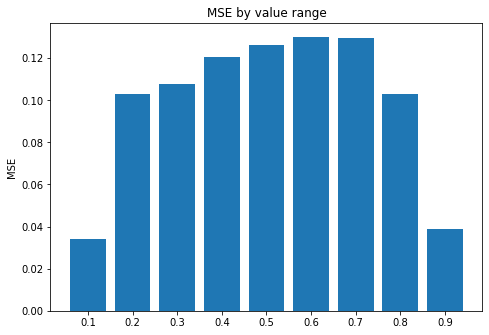

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('MSE by value range')
ax.set_ylabel("MSE")
ax.bar(['0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.8','0.9'],mse)
plt.show()

In [ ]:
test_data  = df[is_test_data].reset_index(drop=True)
mse_topic = {}
for el in test_data['topic'].unique():
  mse_topic[el] = [0,0,0]
for i in range(test_data.shape[0]):
  mse_topic[test_data['topic'][i]][0]+=(ris[i][0]-Y_test[i])**2
  mse_topic[test_data['topic'][i]][1]+=1

for i in range(test_data.shape[0]): 
  mse_topic[test_data['topic'][i]][2]= mse_topic[test_data['topic'][i]][0]/mse_topic[test_data['topic'][i]][1]



In [ ]:
pd.DataFrame.from_dict(mse_topic,orient='index',columns=['tot_mse', 'size', 'mse']).drop(['tot_mse','size'],axis=1)

,mse
Holocaust denial should be a criminal offence,0.120940
We should prohibit women in combat,0.114560
The use of public defenders should be mandatory,0.117140
We should ban factory farming,0.074360
We should adopt libertarianism,0.110478
We should abolish the three-strikes laws,0.095094
We should prohibit school prayer,0.102039
We should ban targeted killing,0.111434
We should legalize cannabis,0.085343
We should adopt atheism,0.124196
